# Compare Greedy Algorithm to Degree Centrality
This code goes through different numbers of starting set sizes and computes both the most degree central and the greedy approximated starting set. It then runs the simulation on both of them seperately and compares the resulting cascade sizes. Additionaly, it applies the function that the greedy algorithm uses to estimate the cascade size on both sets. Then for each size, the mean over multiple samples is plotted.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from copy import deepcopy

import os
import sys
sys.path.append(os.path.dirname(os.path.abspath('')))

from model.agent import Agent
from model.world import World

from model.utils import *
from model.news import News
from model.agent import AgentState

In [2]:
def cascadesize(world):
    return sum([1 if a.is_active() else 0 for a in world.agents.values()])

def measure_cascadesize(world, starting, max_iter):
    for a in starting.keys():
        a.states[starting[a]] = AgentState.ACTIVE
    for iter in range(1, max_iter):
        x = world.update(verbose=True)
        if x == 0:
            break
    return cascadesize(world)

In [3]:
def comp_starting_sets(worlds, sets, max_iter = 20):
    ccs = []
    for s, w in zip(sets, worlds):
        ccs.append(measure_cascadesize(w, s, max_iter))
    return ccs

In [4]:
def compute(sizes, samples = 5):
    """
    takes very long to run!
    """
    c_greedy = [0 for _ in range(len(sizes))]
    c_degree = [0 for _ in range(len(sizes))]
    est_greedy = [0 for _ in range(len(sizes))]
    est_degree = [0 for _ in range(len(sizes))]
    i = 0
    for k in sizes:
        for _ in range(samples):
            sensation_news = 0.5
            decay_parameter_news = 0
            n1 = News(0, sensation_news, decay_parameter_news)
            news1 = {n1.name: n1}
            number_agents = 200
            names_agents = [_ for _ in range(number_agents)]
            threshold = np.random.random(number_agents)
            independence = np.random.random(number_agents)
            w1 = construct_world(names_agents, threshold, independence, news1)
            w2 = deepcopy(w1)
            kset = approx_most_influential(w1, k, sample_size=25, verbose=False) #THIS TAKES SOME TIME !!!
            s1 = {}
            for agent in kset:
                s1[agent] = 0
            degree_centrality = []
            for _ in range(k):
                best = None
                bdeg = -1
                for a in w2.graph.nodes():
                    if w2.agents[a] in degree_centrality:
                        continue
                    d = w2.graph.out_degree(a)
                    if d > bdeg:
                        bdeg = d
                        best = w2.agents[a]
                degree_centrality.append(best)
            s2 = {}
            for agent in degree_centrality:
                s2[agent] = 0
            print([a.name for a in kset])
            print([a.name for a in degree_centrality])
            #reapplying the estimation for the influence used in the greedy algorithm to the solutions
            est_greedy[i] += get_expected_number_of_influenced_agents(w1, [a.name for a in kset], 100) / np.float64(samples)
            est_degree[i] += get_expected_number_of_influenced_agents(w2, [a.name for a in degree_centrality], 100) / np.float64(samples)
            n = 50
            c1, c2 = comp_starting_sets([w1, w2], [s1, s2], n)
            c_greedy[i] += c1 / np.float64(samples)
            c_degree[i] += c2 / np.float64(samples)
        print(k)
        i += 1
    return (c_greedy, c_degree, est_greedy, est_degree)

In [5]:
s = [1,3,5,10,25,50]
c_greedy, c_degree, est_greedy, est_degree = compute(s)

[0]
[0]
[52]
[3]
[3]
[3]
[3]
[3]
[12]
[12]
1
[3, 11, 98]
[4, 3, 12]
[89, 9, 20]
[3, 9, 2]
[1, 6, 0]
[1, 3, 11]
[3, 0, 6]
[3, 0, 4]
[3, 81, 54]
[3, 8, 2]
3
[3, 13, 61, 7, 59]
[3, 0, 6, 5, 4]
[3, 25, 0, 19, 9]
[3, 0, 25, 8, 19]
[3, 1, 22, 19, 69]
[3, 1, 0, 8, 6]
[2, 16, 9, 22, 93]
[3, 4, 0, 11, 2]
[95, 33, 10, 26, 51]
[0, 3, 4, 10, 32]
5
[2, 8, 3, 85, 5, 20, 84, 99, 55, 9]
[2, 8, 3, 5, 9, 1, 4, 16, 6, 20]
[88, 3, 1, 6, 0, 17, 86, 28, 87, 9]
[3, 4, 1, 8, 9, 6, 17, 5, 33, 18]
[3, 48, 45, 19, 5, 39, 14, 21, 49, 71]
[3, 5, 1, 2, 0, 8, 6, 20, 24, 16]
[2, 33, 8, 65, 3, 68, 78, 4, 6, 34]
[2, 8, 0, 3, 17, 24, 6, 4, 5, 10]
[1, 80, 3, 51, 45, 18, 59, 37, 55, 34]
[1, 3, 0, 5, 4, 16, 8, 11, 25, 26]
10
[3, 0, 2, 4, 32, 10, 19, 72, 53, 97, 33, 39, 84, 92, 8, 70, 66, 68, 34, 74, 54, 80, 96, 82, 85]
[3, 0, 4, 2, 9, 8, 10, 32, 1, 12, 6, 5, 13, 17, 18, 43, 14, 20, 33, 16, 19, 36, 37, 39, 49]
[3, 80, 71, 54, 18, 96, 97, 5, 63, 11, 20, 58, 12, 42, 65, 98, 49, 16, 23, 15, 60, 9, 67, 33, 90]
[3, 2, 0, 4, 11, 

In [6]:
print(c_greedy, c_degree, est_greedy, est_degree, sep="\n")

[30.799999999999997, 45.400000000000006, 55.8, 68.8, 80.0, 88.4]
[43.2, 57.6, 71.4, 71.6, 79.8, 86.8]
[14.904, 25.972, 34.18000000000001, 46.352000000000004, 62.25, 79.606]
[15.935999999999998, 28.21, 37.884, 47.24, 62.174, 75.348]


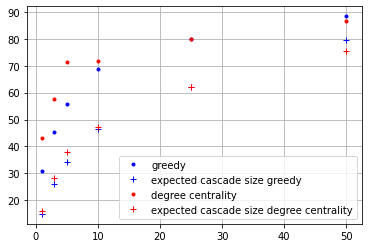

In [7]:
plt.plot(s, c_greedy, "b.", label="greedy")
plt.plot(s, est_greedy, "b+", label="expected cascade size greedy")
plt.plot(s, c_degree, "r.", label="degree centrality")
plt.plot(s, est_degree, "r+", label="expected cascade size degree centrality")
plt.grid()
plt.legend()
plt.show()